In [82]:
# Importing libraries
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Sequential
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST, CIFAR10, GTSRB
import matplotlib.pyplot as plt
#%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import PIL

In [83]:
class OcclusionFirstLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in = size_in  # Size in = 4
        self.size_out = size_out # Size out = 2*(m+n)
        weights, bias = self.init_weights_bias(size_in, size_out)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, corner, box):
        input = torch.tensor([corner[0], box[0], corner[1], box[1]]).type(torch.FloatTensor)
        return torch.matmul(self.weights, input) + self.bias

    def init_weights_bias(self, size_in, size_out):
        weights = torch.zeros(size_out, size_in)   # in uniform case out = 2*(m+n), in = 4
        bias = torch.zeros(size_out)

        # set the weight
        # block sizes are used to fit all weights of the layer in one matrix
        block_size = (size_out) // 4   # out_size = 2*(m+n), in uniform case colour = 0 => block_size = 2*(m+n) // 4 usually m = n
        for i in range(4):
            if i == 0 or i == 2:
                for j in range(block_size):
                    weights[i * block_size + j, i] = 1
                    bias[i * block_size + j] = -(j + 1)
            elif i == 1 or i == 3:
                for j in range(block_size):
                    weights[i * block_size + j, i - 1] = -1
                    weights[i * block_size + j, i] = -1
                    bias[i * block_size + j] = j + 2

        # print(weights, bias)
        return weights, bias


In [84]:
class OcclusionSecondLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in = size_in  # Size in = 2*(m+n)
        self.sie_out = size_out # Size out = m + n
        weights, bias = self.init_weights_bias(size_in, size_out)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, x):
        return torch.matmul(self.weights, x) + self.bias

    def init_weights_bias(self, size_in, size_out):
        weights = torch.zeros(size_out, size_in)
        block_size = (size_out) // 2
        for i in range(2):
            for j in range(block_size):
                weights[i * block_size + j, 2 * i * block_size + j] = -1
                weights[i * block_size + j, 2 * i * block_size + block_size + j] = -1
        bias = torch.ones(size_out)
        # print(weights, bias)
        return weights, bias

In [85]:
class OcclusionThirdLayer(nn.Module):
    def __init__(self, size_in, size_out, image_shape):
        super().__init__()
        self.size_in = size_in     # Size in = m + n
        self.size_out = size_out   # Size out = m*n
        self.image_shape = image_shape
        weights, bias = self.init_weights_bias(size_in, size_out, image_shape)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, x):
        return torch.matmul(self.weights, x) + self.bias

    def init_weights_bias(self, size_in, size_out, image_shape):
        weights = torch.zeros(size_out, size_in)
        bias = torch.zeros(size_out)
        image_channel, image_height, image_width = image_shape
        input_block_size = (size_in - image_channel) // 2
        block_size = image_height

        for i in range(image_width):
            for j in range(block_size):
                weights[i * block_size + j, i] = 1
                weights[i * block_size + j, input_block_size + j] = 1

        bias = -torch.ones(size_out)
        # print(weights, bias)
        return weights, bias

In [86]:
class OcclusionFourthLayer(nn.Module):
    def __init__(self, size_in, size_out, image, occlusion_colour, is_multiform, epsilon):
        super().__init__()
        self.size_in = size_in    # Size in = m*n
        self.size_out = size_out  # Size_out = m*n
        self.occlusion_colour = occlusion_colour
        self.image = image
        self.image_channel, self.image_height, self.image_width = image.shape
        weights, bias = self.init_weights_bias(size_in, size_out, image, occlusion_colour, is_multiform, epsilon)
        self.weights = nn.Parameter(weights, requires_grad=False)
        self.bias = nn.Parameter(bias, requires_grad=False)

    def forward(self, x):
        return (torch.matmul(self.weights, x)) + self.bias

    def init_weights_bias(self, size_in, size_out, image, occlusion_colour, is_multiform, epsilon):
        assert isinstance(image, torch.Tensor)
        image_flatten = image.view(-1)
        image_channel, image_height, image_width = image.shape

        if is_multiform:
            # Difference between original pixel values and occluded pixel values
            epsilons = (epsilon - (-epsilon)) * torch.rand(size_out) + (-epsilon)

        weights = torch.zeros(size_out, size_in)

        for channel in range(image_channel):
            for i in range(size_out // image_channel):
                if not is_multiform:
                    # coloring function - xi = u - xi
                    weights[channel * image_height * image_width + i, i] = occlusion_colour[channel] - image_flatten[channel * image_height * image_width + i]
                else:
                    # coloring function - xi = delta_i
                    weights[channel * image_height * image_width + i, i] = torch.round(epsilons[channel * image_height * image_width + i],decimals=4)

        # The bias is the flattened image vector
        bias = image_flatten
        # print(weights, bias)
        return weights, bias

In [87]:
class Clamp(nn.Module):
    def __init__(self):
        super(Clamp, self).__init__()

    def forward(self, x: torch.tensor):
        # Clamps the values at 1
        return torch.where(x > 1.0, 1.0, x)

In [88]:
def forward(image, channels, width, height, corner, box, image_shape, occlusion_colour, is_multiform, epsilon):
    c,m,n = channels, width, height
    a,b = corner
    w,h = box

    # Initialization
    first_layer = OcclusionFirstLayer(4, 2*(m+n))
    second_layer = OcclusionSecondLayer(2*(m+n), (m+n))
    third_layer = OcclusionThirdLayer((m+n), m*n, image_shape)
    fourth_layer = OcclusionFourthLayer(m*n, c*m*n, image, occlusion_colour, is_multiform, epsilon)

    first_out = torch.relu(first_layer((a,b), (w,h)))
    second_out = torch.relu(second_layer(first_out))
    third_out = torch.relu(third_layer(second_out))
    # To handle pixel values greater than
    activation = Clamp()
    fourth_out = activation(torch.relu(fourth_layer(third_out)))

    return first_out, second_out, third_out, fourth_out

In [89]:
mnist = MNIST(root = 'data/', train = True, transform = transforms.ToTensor(),download=True)

cifar10 = CIFAR10(root = 'data/', train = True, transform = transforms.ToTensor(),download=True)

gtsrb = GTSRB(root = 'data/', split='train', transform = transforms.Compose([
    transforms.Resize((32,32),transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
]),download=True)

Files already downloaded and verified


### MNIST

In [90]:
image_tensor, label = mnist[15001]

Text(0.5, 1.0, 'Original Image')

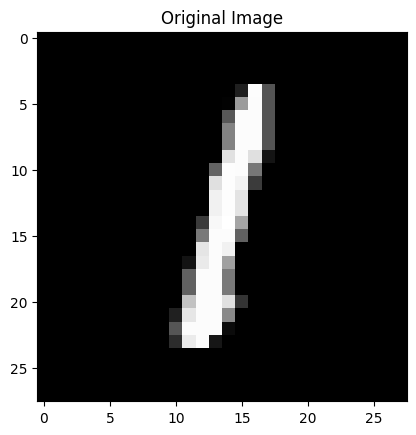

In [91]:
plt.imshow(transforms.ToPILImage()(image_tensor),cmap='gray')
plt.title('Original Image')

In [92]:
a = 4
b = 7
w = 6
h = 10
c = image_tensor.shape[0]  # no. of channels
m = image_tensor.shape[1]  # width
n = image_tensor.shape[2]  # height
shape = image_tensor.shape

In [93]:
# If occlusion is uniform we need to define the color for all channels
occlusion_color = torch.rand(c)   # 234 * torch.ones(c)

# If occlusion is multiform we need to set flag as True and pass an epsilon value
is_multiform = True
epsilon = 0.7

# r1, r2, r3 are outputs of the previous layers
r1, r2, r3, result = forward(image_tensor, c, m, n, (a,b), (w,h), shape, occlusion_color, is_multiform, epsilon)

Text(0.5, 1.0, 'Occluded Image')

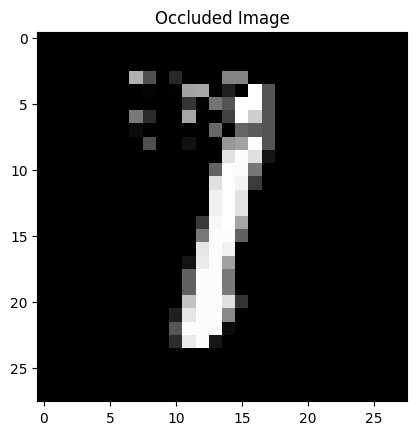

In [94]:
result = torch.reshape(result,(c,m,n))
plt.imshow(transforms.ToPILImage()(result),cmap='gray')
plt.title('Occluded Image')

Text(0.5, 1.0, 'Occluded Image')

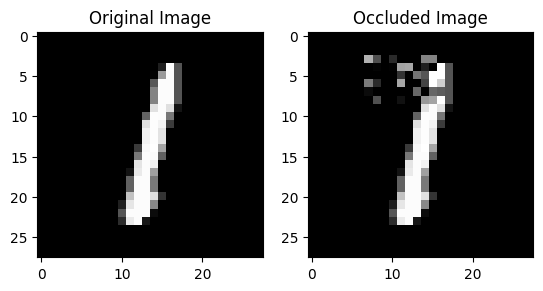

In [95]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(image_tensor[0],cmap='gray')
axarr[1].imshow(result[0],cmap='gray')
axarr[0].set_title("Original Image")
axarr[1].set_title("Occluded Image")

### GTSRB

In [96]:
image_tensor, label = gtsrb[3563]

Text(0.5, 1.0, 'Original Image')

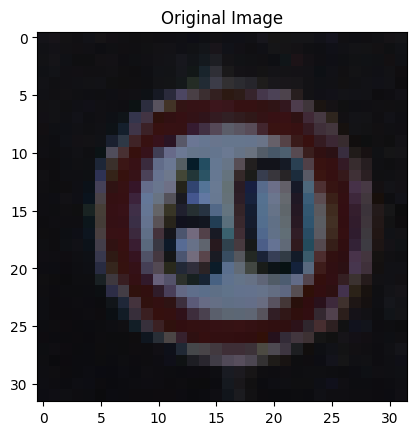

In [97]:
plt.imshow(transforms.ToPILImage()(image_tensor))
plt.title('Original Image')

In [98]:
a = 2.2
b = 3
w = 6
h = 2
c = image_tensor.shape[0]
m = image_tensor.shape[1]
n = image_tensor.shape[2]
shape = image_tensor.shape

In [99]:
# If occlusion is uniform we need to define the color for all channels
occlusion_color = torch.rand(c)
r1, r2, r3, result = forward(image_tensor,c, m, n, (a,b), (w,h), shape, occlusion_color, True, 0.3)

Text(0.5, 1.0, 'Occluded Image')

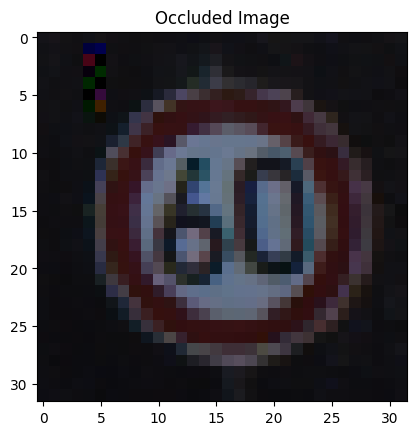

In [100]:
result = torch.reshape(result,(c,m,n))
plt.imshow(transforms.ToPILImage()(result))
plt.title('Occluded Image')

Text(0.5, 1.0, 'Occluded Image')

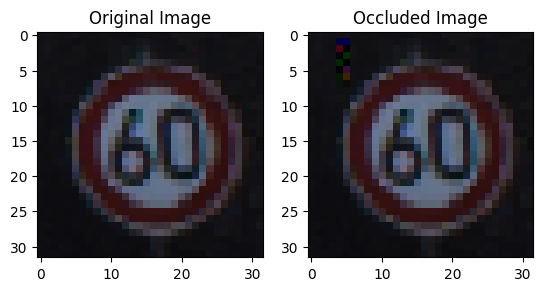

In [101]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(transforms.ToPILImage()(image_tensor))
axarr[1].imshow(transforms.ToPILImage()(result))
axarr[0].set_title("Original Image")
axarr[1].set_title("Occluded Image")

### CIFAR-10

In [102]:
image_tensor, label = cifar10[14747]

Text(0.5, 1.0, 'Original Image')

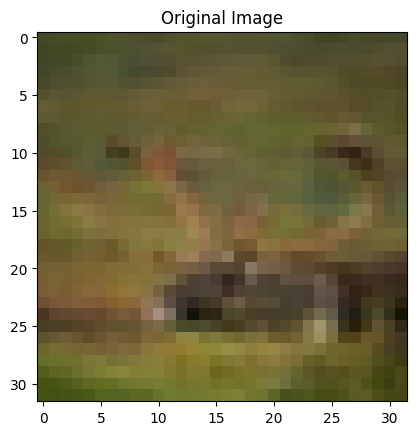

In [103]:
plt.imshow(transforms.ToPILImage()(image_tensor))
plt.title('Original Image')

In [104]:
a = 22
b = 3
w = 6
h = 20
c = image_tensor.shape[0]
m = image_tensor.shape[1]
n = image_tensor.shape[2]
shape = image_tensor.shape

In [105]:
# If occlusion is uniform we need to define the color for all channels
occlusion_color = torch.rand(c)
r1, r2, r3, result = forward(image_tensor,c, m, n, (a,b), (w,h), shape, occlusion_color, True, 0.3)

Text(0.5, 1.0, 'Occluded Image')

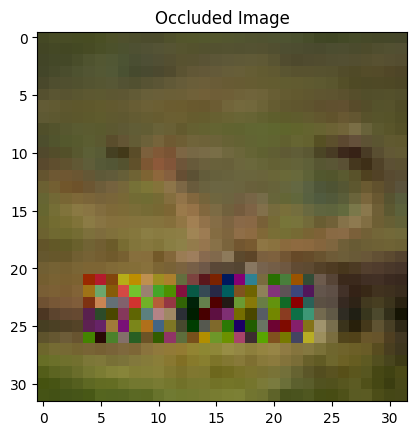

In [106]:
result = torch.reshape(result,(c,m,n))
plt.imshow(transforms.ToPILImage()(result))
plt.title('Occluded Image')

Text(0.5, 1.0, 'Occluded Image')

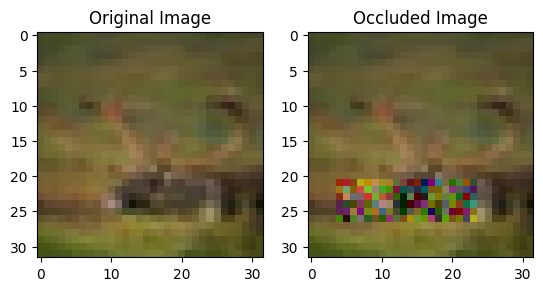

In [107]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(transforms.ToPILImage()(image_tensor))
axarr[1].imshow(transforms.ToPILImage()(result))
axarr[0].set_title("Original Image")
axarr[1].set_title("Occluded Image")

Text(0.5, 1.0, 'Difference between original image and occluded image')

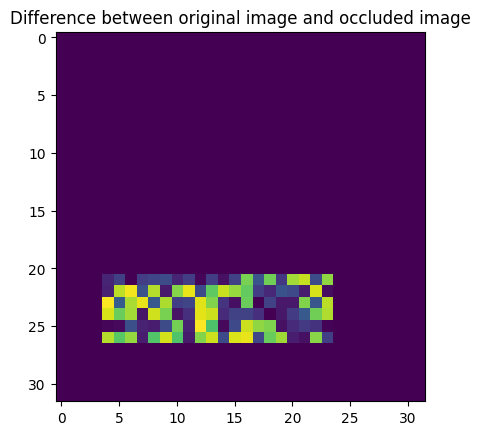

In [108]:
plt.imshow(transforms.ToPILImage()(result[0] - image_tensor[0]))
plt.title("Difference between original image and occluded image")